In [1]:
import os
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from regressCNN import RegressionPCA
from widgets_HSE import getBinaryimage, getSamplePoints, save_obj 

from obj_utils.io import *

/home/dgist/miniconda3/envs/HSE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda_available = torch.cuda.is_available()
print('cuda available:', cuda_available)

device = torch.device('cuda:0' if cuda_available else 'cpu')
print('using device', device)

cuda available: True
using device cuda:0


# Inference on Test Set

In [3]:
def repeat_data(x):
    row, col = x.shape
    data = np.zeros([row, col+2])
    data[:, 0] = x[:, -1]
    data[:, 1:-1] = x
    data[:, -1] = x[:, 0]
    return data

class HSEDataset(Dataset):
    def __init__(self, data_path, transform=None, predict_only=False):
        self.data = []
        self.transform = transform

        for dir in tqdm(os.listdir(data_path), desc='loading data'):
            path = os.path.join(data_path, dir)
            f = np.load(os.path.join(path, 'frontal.npy'))
            l = np.load(os.path.join(path, 'lateral.npy'))
            s = 0 if predict_only else np.load(os.path.join(path, 'shape.npy'))

            self.data.append([dir, f, l, s])

    def __getitem__(self, i):
        name, f, l, s = self.data[i]

        f = repeat_data(f.transpose())
        l = repeat_data(l.transpose())
        return name, f, l, s

    def __len__(self):
        return len(self.data)

In [4]:
pca_base = np.load('./infer/caesar_pca_base.npy')
mean = np.load('./infer/caesar_mean.npy')

mesh_faces = np.load('./infer/face.npy')

def shape_parameter_to_vertices(shape_parameter, height):
    vertices = shape_parameter.dot(pca_base) + mean.reshape((-1))
    vertices = vertices.reshape((6449 ,3))

    v_y = vertices[:, 1]
    height_out = max(v_y) - min(v_y)
    scale = height / height_out

    vertices *= scale

    return vertices

In [5]:
model_name = './train/model/checkpoint_Thu_May__4_05:07:47_2023/male_1000.ckpt'
infer_model = RegressionPCA(22).to(device)
infer_model.load_state_dict(torch.load(model_name))
infer_model.eval()
print('model loaded')

model loaded


In [6]:
test_dataset = HSEDataset('../dataset-generation/datasets/HSE/sample_648/test/')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1)

loading data: 100%|██████████| 886/886 [00:01<00:00, 787.90it/s]


In [7]:
def infer(frontal, lateral):
    with torch.no_grad():
        result = infer_model(frontal, lateral)
    
    return result

In [8]:
model_name = 'checkpoint_Thu_May__4_05:07:47_2023'

test_input_path = '../dataset-generation/datasets/HSE/sample_648/test/'
obj_path = '../dataset-generation/obj/scaled/'
result_path = f'./test_results/{model_name}'

In [9]:
for data in tqdm(test_dataloader):
    name, f, l, s = data
    name = name[0]

    v_gt, _ = load_obj(os.path.join(obj_path, name+'.obj'))
    v_y_gt = v_gt[:, 1]
    height_gt = max(v_y_gt) - min(v_y_gt)

    f = f.to(device, dtype=torch.float)
    l = l.to(device, dtype=torch.float)
    result = infer(f, l)
    result = np.array(result.to('cpu'))

    v_out = shape_parameter_to_vertices(result, height_gt)
    
    save_path = os.path.join(result_path, name)
    os.makedirs(save_path, exist_ok=True)
    save_obj(os.path.join(save_path, 'mesh_gt.obj'), v_gt, mesh_faces)
    save_obj(os.path.join(save_path, 'mesh_out.obj'), v_out, mesh_faces)

100%|██████████| 886/886 [05:50<00:00,  2.53it/s]


# Calculate V2V

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from trimesh.registration import icp

from obj_utils.io import *
from obj_utils.misc import *

In [2]:
result_path = './test_results/checkpoint_Thu_May__4_05:07:47_2023'

In [3]:
v2v_list = []

for data in tqdm(os.listdir(result_path)):
    v_gt, _ = load_obj(os.path.join(result_path, data, 'mesh_gt.obj'))
    v_out, _ = load_obj(os.path.join(result_path, data, 'mesh_out.obj'))

    _, v_out_trans, _ = icp(v_out, v_gt, scale=False)
    
    diff = v_gt - v_out_trans
    v2v = np.linalg.norm(diff, axis=1).mean()
    v2v_list.append(v2v)

    green, red = np.array([0., 1., 0.]), np.array([1., 0., 0.])
    v_gt_colored = add_vertices_color(v_gt, green)
    v_out_trans_colored = add_vertices_color(v_out_trans, red)

    v_merged = merge_vertices(v_gt_colored, v_out_trans_colored)
    save_obj(os.path.join(result_path, data, 'mesh_merged.obj'), v_merged, [])

v2v_arr = np.array(v2v_list)

100%|██████████| 886/886 [04:04<00:00,  3.63it/s]


In [4]:
print('min:', v2v_arr.min())
print('max:', v2v_arr.max())
print('avg, std:', v2v_arr.mean(), v2v_arr.std())

min: 0.0009585225474617769
max: 0.022997166704491753
avg, std: 0.004361013519402105 0.003633848731066159


In [9]:
idx = np.where(v2v_arr > 0.02)[0]
data_list = os.listdir(result_path)

for i in idx:
    print(data_list[i])

caesar_3828
caesar_3876
caesar_617
caesar_930


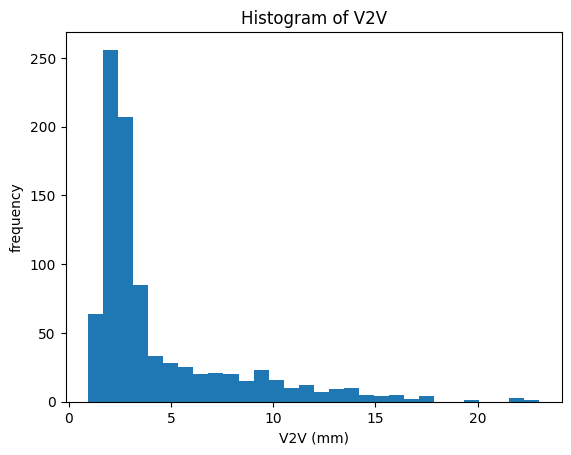

In [6]:
hist, bins = np.histogram(v2v_arr*1000, bins=30)

plt.title('Histogram of V2V')
plt.xlabel('V2V (mm)')
plt.ylabel('frequency')

plt.hist(bins[:-1], bins, weights=hist)
plt.show()